# CITE-seq reference mapping with totalVI

With totalVI, we can train a reference model that can be used for mapping new query data. Here we dive into this functionality.

If you use totalVI, please consider citing:

- Gayoso, A., Steier, Z., Lopez, R., Regier, J., Nazor, K. L., Streets, A., & Yosef, N. (2021). Joint probabilistic modeling of single-cell multi-omic data with totalVI. Nature Methods, 18(3), 272-282.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pooch
import scanpy as sc
import scrublet as scr
import scvi
import seaborn as sns
import torch
import umap
from scvi.model import TOTALVI
from sklearn.ensemble import RandomForestClassifier

## Building a reference model

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

This dataset was filtered as described in the scvi-tools manuscript (low quality cells, doublets, lowly expressed genes, etc.).

```{important}
Here we use the argument `mask_protein_batches=5`. What this does is treats the protein data in 5/24 of the batches in this dataset as missing. This will help totalVI integrate query data that has a subset of the proteins measured in this dataset or no proteins at all (i.e., just scRNA-seq data).
```

In [5]:
adata = scvi.data.pbmc_seurat_v4_cite_seq(
    save_path=save_dir.name,
    mask_protein_batches=5,
)

INFO     Downloading file at /tmp/tmpdi9958fj/pbmc_seurat_v4.h5ad                                                  


Downloading...:   0%|          | 0/1002579.0 [00:00<?, ?it/s]

In [6]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="orig.ident",
    subset=True,
    layer="counts",
)
adata

AnnData object with n_obs × n_vars = 152094 × 4000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size'
    var: 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    obsm: 'protein_counts'
    layers: 'counts'

In [8]:
TOTALVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="orig.ident",
    protein_expression_obsm_key="protein_counts",
)

INFO     Using column names from columns of adata.obsm['protein_counts']                                           
INFO     Found batches with missing protein expression                                                             


/tmp/ipykernel_149879/4291921922.py:1: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  TOTALVI.setup_anndata(


### Prepare and run model

Here we use the scArches-specific totalVI parameters, as shown in the scArches tutorial.

Rather than training the model here, which would take 1 hour, we instead download a pretrained object.

In [9]:
def download_model(save_path: str, fname: str = "legacy_seurat_reference_model"):
    """Download the pre-trained model."""
    paths = pooch.retrieve(
        url="https://exampledata.scverse.org/scvi-tools/seurat_reference_model.zip",
        known_hash="422706d6af4ec6b3b91f547d7e8c97812b86a548e0d19b1d85d9cfed686a5130",
        fname=fname,
        path=save_path,
        processor=pooch.Unzip(),
    )
    paths.sort()
    return str(Path(paths[0]).parent)

In [10]:
legacy_model_dir = download_model(save_dir.name)
model_dir = os.path.join(save_dir.name, "seurat_reference_model")
TOTALVI.convert_legacy_save(legacy_model_dir, model_dir)

model = TOTALVI.load(model_dir, adata=adata)

Unzipping contents of '/tmp/tmpdi9958fj/legacy_seurat_reference_model' to '/tmp/tmpdi9958fj/legacy_seurat_reference_model.unzip'


INFO     File /tmp/tmpdi9958fj/seurat_reference_model/model.pt already downloaded                                  
INFO     Found batches with missing protein expression                                                             
INFO     Computing empirical prior initialization for protein background.                                          


/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/model/base/_base_model.py:899: UserWarning: `var_names` for the loaded `model` does not match those used to train the model. For valid results, the former should match the latter.
  _validate_var_names(adata, var_names)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/model/base/_save_load.py:158: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  model = cls(adata, **non_kwargs, **kwargs)


In [11]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 0.13.0.

Setup via `TOTALVI.setup_anndata` with arguments:

{
│   'protein_expression_obsm_key': 'protein_counts',
│   'protein_names_uns_key': '_protein_names',
│   'batch_key': 'orig.ident',
│   'panel_key': None,
│   'layer': 'counts',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   24   │
│         n_cells          │ 152094 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│        n_proteins        │  217   │
│          n_vars          │  4000  │
└──────────────────────────┴────────┘

                 Data Registry                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃     scvi-tools Location      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │    adata.layers['counts']    │
│    batch     │   adata.obs['_scvi_batch']   │
│    labels    │  adata.obs['_scvi_labels']   │
│   proteins   │ adata.obsm['protein_counts'] │
└──────────────┴──────────────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │    P1_0    │          0          │
│                         │    P1_3    │          1          │
│                         │    P1_7    │          2          │
│                         │    P2_0    │          3          │
│                         │    P2_3    │          4          │
│                         │    P2_7    │          5          │
│                         │    P3_0    │          6          │
│                         │    P3_3    │          7          │
│                         │    P3_7    │          8          │
│                         │    P4_0    │          9          │
│                         │    P4_3    │         10          │
│                         │    P4_7    │         11          │
│                         │    P5_0    │         12          │
│                         │    P5_3    │         13          │
│                         │    P5_7    │         14          │
│                         │    P6_0    │         15          │
│                         │    P6_3    │         16          │
│                         │    P6_7    │         17          │
│                         │    P7_0    │         18          │
│                         │    P7_3    │         19          │
│                         │    P7_7    │         20          │
│                         │    P8_0    │         21          │
│                         │    P8_3    │         22          │
│                         │    P8_7    │         23          │
└─────────────────────────┴────────────┴─────────────────────┘

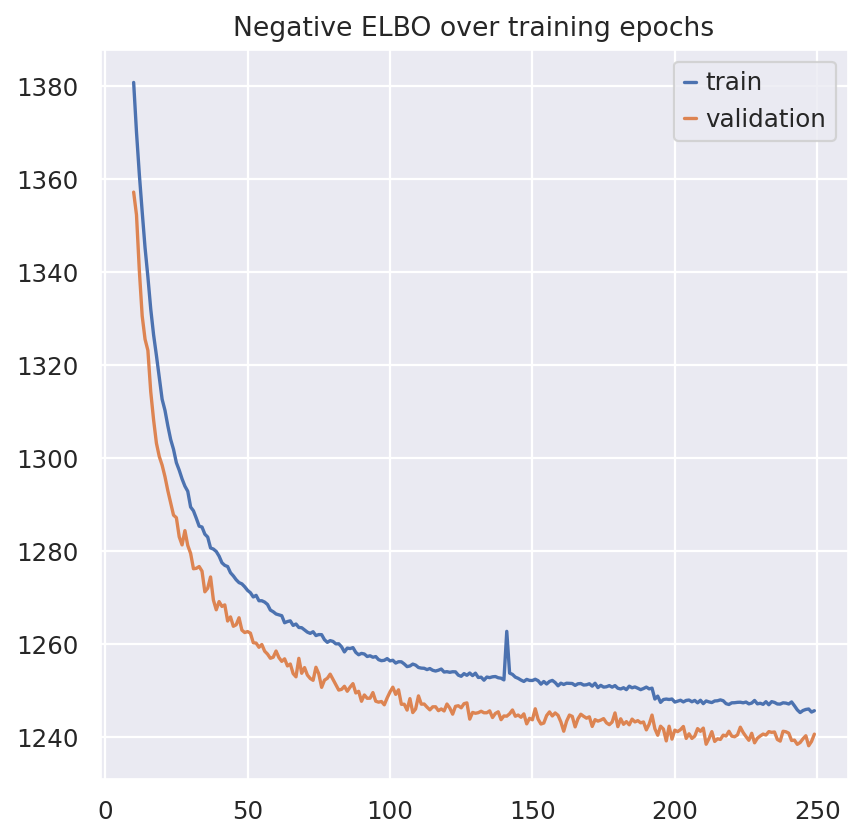

In [12]:
plt.plot(model.history["elbo_train"].iloc[10:], label="train")
plt.plot(model.history["elbo_validation"].iloc[10:], label="validation")
plt.title("Negative ELBO over training epochs")
plt.legend()

In [13]:
TOTALVI_LATENT_KEY = "X_totalvi"

adata.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()

### Train a classifier on the latent space

The representation of the reference data will not change when the model gets updated with query data. Therefore, we can train any simple classifier on the latent space. Here we use a Random Forest from scikit-learn.

By storing the classifier object in our totalVI instance (and giving it an attribute that ends with `_`), we can automatically save and load this classifier along with our model.

In [14]:
y_train = adata.obs["celltype.l2"].astype("category").cat.codes.to_numpy()
X_train = adata.obsm[TOTALVI_LATENT_KEY]
clf = RandomForestClassifier(
    random_state=1,
    class_weight="balanced_subsample",
    verbose=1,
    n_jobs=-1,
)
clf.fit(X_train, y_train)

model.latent_space_classifer_ = clf

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    2.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


### Inspect reference model

We can view the latent space using UMAP and plot the study-derived cell type labels.

Here we use the umap API instead of scanpy so that we can later use the same umap object on the query data.

In [15]:
TOTALVI_UMAP_KEY = "X_umap"

X = adata.obsm[TOTALVI_LATENT_KEY]
trans = umap.UMAP(
    n_neighbors=10,
    random_state=42,
    min_dist=0.4,
)
adata.obsm[TOTALVI_UMAP_KEY] = trans.fit_transform(X)

model.umap_op_ = trans

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


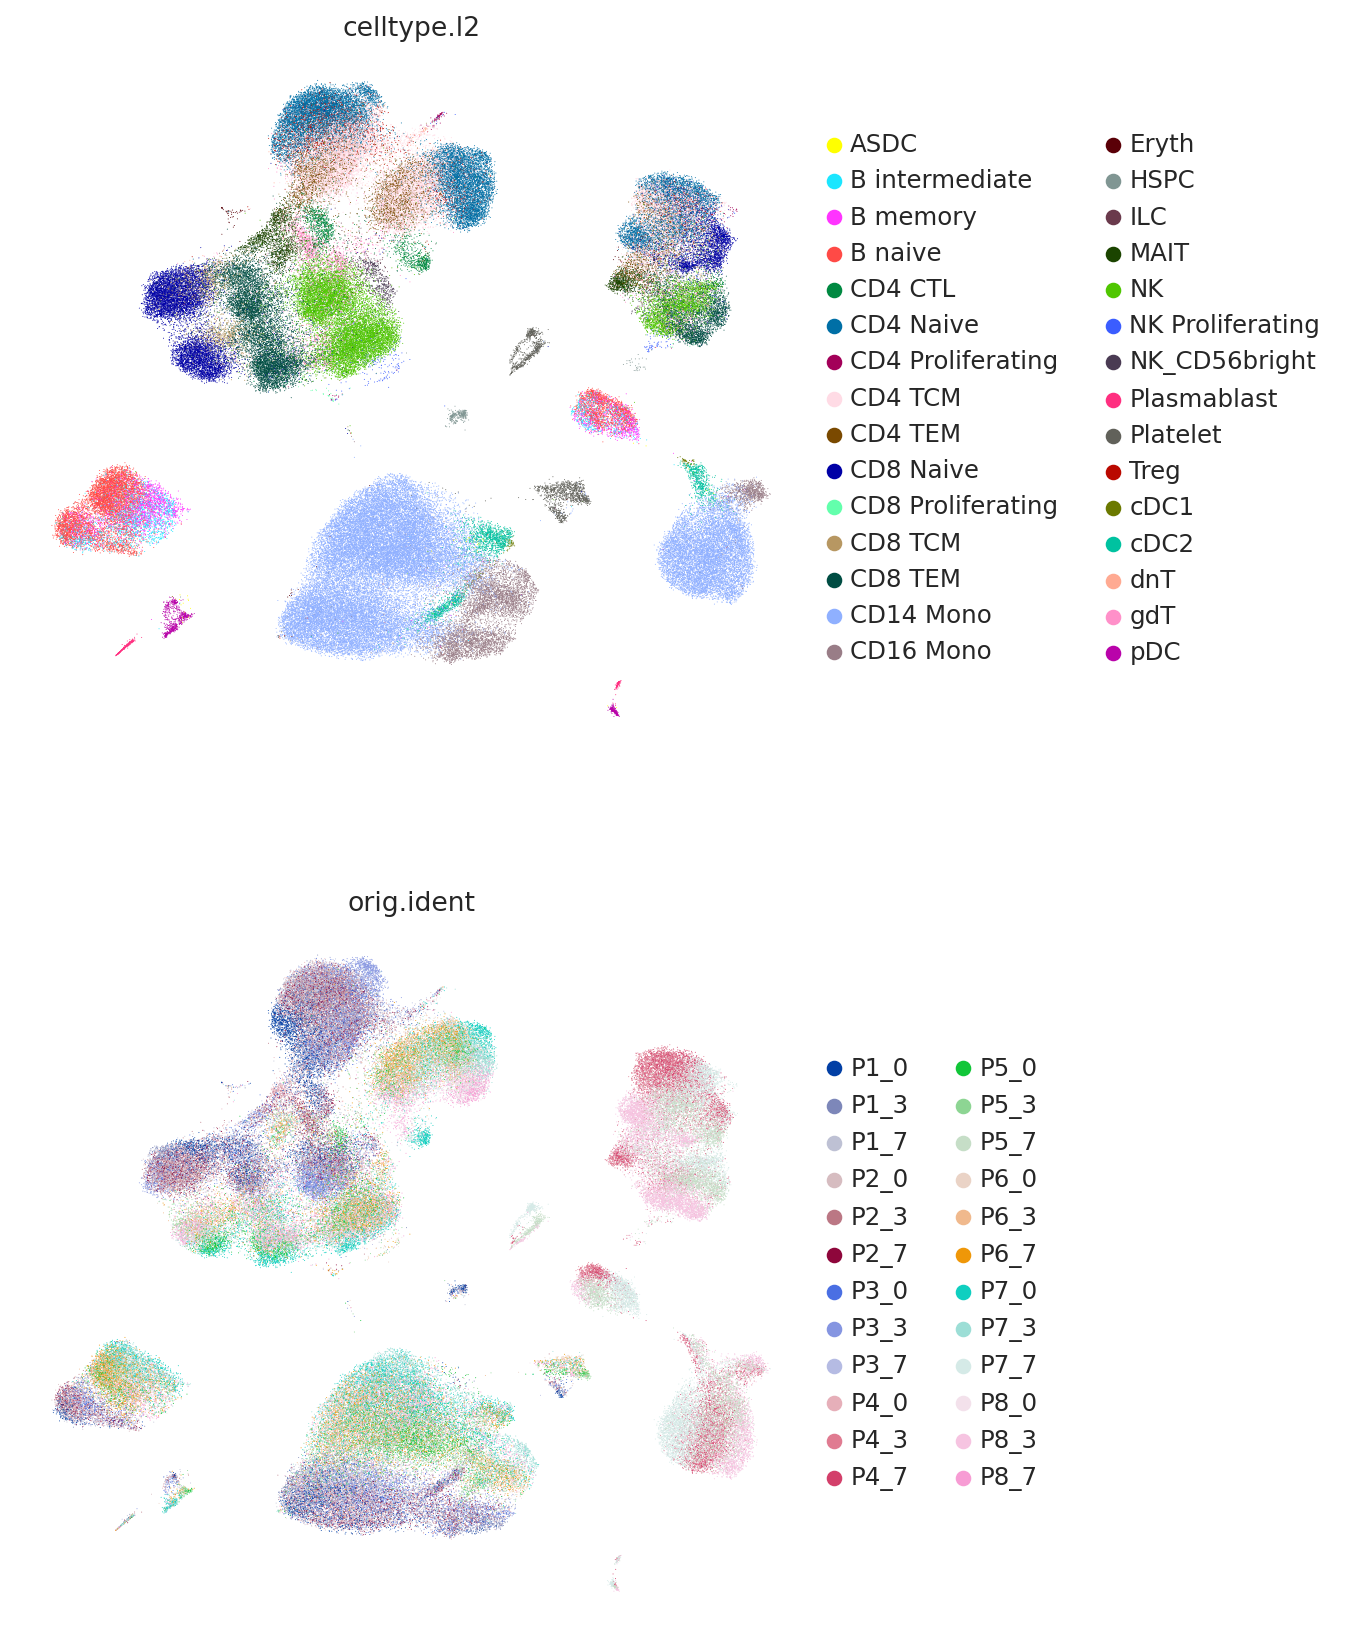

In [16]:
sc.pl.umap(
    adata,
    color=["celltype.l2", "orig.ident"],
    frameon=False,
    ncols=1,
)

## Map query data

Now we download our query data and cover the preprocessing necessary to map with our reference model.

In this case our query data are also PBMCs and come from the following study:

- Arunachalam, Prabhu S., et al. "Systems biological assessment of immunity to mild versus severe COVID-19 infection in humans." Science 369.6508 (2020): 1210-1220.

This dataset is also CITE-seq, but contains a subset of the proteins of the reference data.

In [17]:
query_path = os.path.join(save_dir.name, "covid_cite.h5ad")

query = sc.read(
    query_path, backup_url="https://exampledata.scverse.org/scvi-tools/covid_cite.h5ad"
)

  0%|          | 0.00/289M [00:00<?, ?B/s]

### Preprocessing

First we remove any doublets from the query dataset using Scrublet. This has to be run per batch, which in this dataset is denoted with `"set"`.

In [18]:
query.obs["doublet_scores"] = 0
query.obs["predicted_doublets"] = True
for s in np.unique(query.obs["set"]):
    mask = query.obs["set"] == s
    counts_matrix = query[mask].X.copy()
    scrub = scr.Scrublet(counts_matrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    query.obs["doublet_scores"].iloc[mask] = doublet_scores
    query.obs["predicted_doublets"].iloc[mask] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 3.8%
Estimated detectable doublet fraction = 41.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.2%
Elapsed time: 26.2 seconds


/tmp/ipykernel_149879/1351898786.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  query.obs["doublet_scores"].iloc[mask] = doublet_scores
/tmp/ipykernel_149879/1351898786.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 6.4%
Estimated detectable doublet fraction = 57.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.2%
Elapsed time: 25.4 seconds


/tmp/ipykernel_149879/1351898786.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  query.obs["doublet_scores"].iloc[mask] = doublet_scores
/tmp/ipykernel_149879/1351898786.py:9: FutureWarning: ChainedAssignmentError: behaviour will change 

Next we do the following:

1. Store the counts in a layer, perform standard preprocessing
1. Add blank metadata that we will later fill in with predicted labels
1. Rename the batch key to correspond to the reference data
1. Add proteins with all 0 counts for the missing proteins in this query dataset

In [19]:
query.layers["counts"] = query.X.copy()
sc.pp.normalize_total(query, target_sum=1e4)
sc.pp.log1p(query)
query.raw = query
# subset to reference vars
query = query[:, adata.var_names].copy()

query.obsm["protein_counts"] = query.obsm["pro_exp"].copy()
query.obs["celltype.l2"] = "Unknown"
query.obs["orig.ident"] = query.obs["set"]
query.obsm["X_umap"] = query.obs[["UMAP1", "UMAP2"]].values

# reorganize query proteins, missing proteins become all 0
for p in adata.obsm["protein_counts"].columns:
    if p not in query.obsm["protein_counts"].columns:
        query.obsm["protein_counts"][p] = 0.0
# ensure columns are in same order
query.obsm["protein_counts"] = query.obsm["protein_counts"].loc[
    :, adata.obsm["protein_counts"].columns
]

/tmp/ipykernel_149879/3669508931.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query.obsm["protein_counts"][p] = 0.0
/tmp/ipykernel_149879/3669508931.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query.obsm["protein_counts"][p] = 0.0
/tmp/ipykernel_149879/3669508931.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

For later visualization, we add some metadata to denote whether the dataset is reference of query

In [20]:
adata.obs["dataset_name"] = "Reference"
query.obs["dataset_name"] = "Query"

### Query model training

In [21]:
query_model = TOTALVI.load_query_data(query, model)
query_model.train(
    max_epochs=150,
    plan_kwargs={"weight_decay": 0.0, "scale_adversarial_loss": 0.0},
)

INFO     Found batches with missing protein expression                                                             
INFO     Computing empirical prior initialization for protein background.                                          


/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/model/base/_save_load.py:158: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  model = cls(adata, **non_kwargs, **kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual op

Training:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


And now we retrieve the latent representation for the query data

In [22]:
TOTALVI_QUERY_LATENT_KEY = "X_totalvi_scarches"

query.obsm[TOTALVI_QUERY_LATENT_KEY] = query_model.get_latent_representation(query)

### Query cell type prediction

We can use the random forest that we previously trained using the latent representation of the query data in the updated model!

In [23]:
# predict cell types of query
predictions = query_model.latent_space_classifer_.predict(query.obsm[TOTALVI_QUERY_LATENT_KEY])
categories = adata.obs["celltype.l2"].astype("category").cat.categories
cat_preds = [categories[i] for i in predictions]
query.obs["celltype.l2"] = cat_preds
query.obs["predicted_l2_scarches"] = cat_preds

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished


### Evaluate label transfer

Now we plot the predicted labels and the labels from the query study (here denoted as `"final_clust_review"`) on the UMAP coordinated used in the query study. We can see that we have an overall strong concordance, but also some important differences. For example, the study found a population of monocytes with interferon signaling, but as the reference contains no such cell type, it can only predict them to be CD14 monocytes.

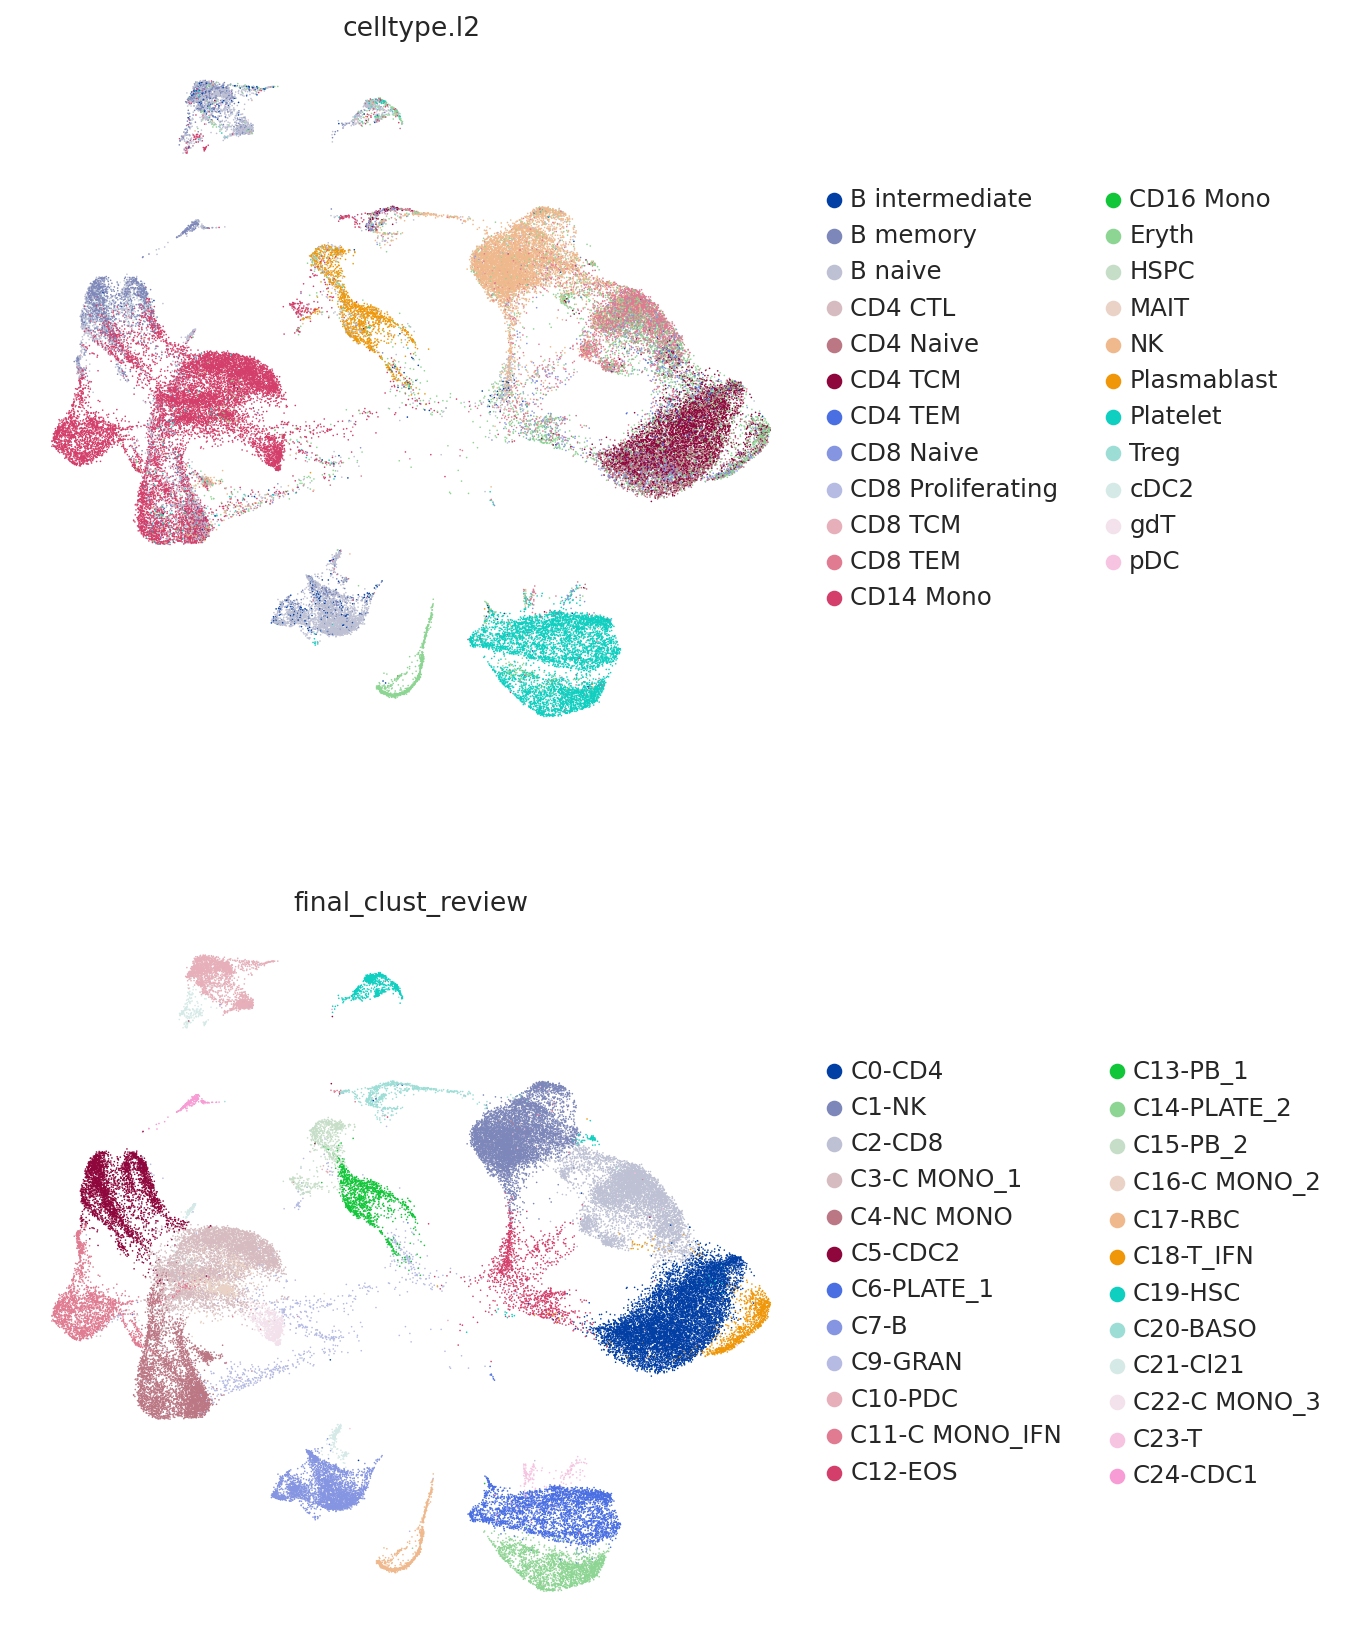

In [24]:
sc.pl.umap(
    query,
    color=["celltype.l2", "final_clust_review"],
    frameon=False,
    ncols=1,
)

### Use reference UMAP

We can also use the same UMAP operator from the reference step to visualize our query data.

In [30]:
TOTALVI_UMAP_PROJECT_KEY = "X_umap_project"

query.obsm[TOTALVI_UMAP_PROJECT_KEY] = query_model.umap_op_.transform(
    query.obsm[TOTALVI_QUERY_LATENT_KEY]
)

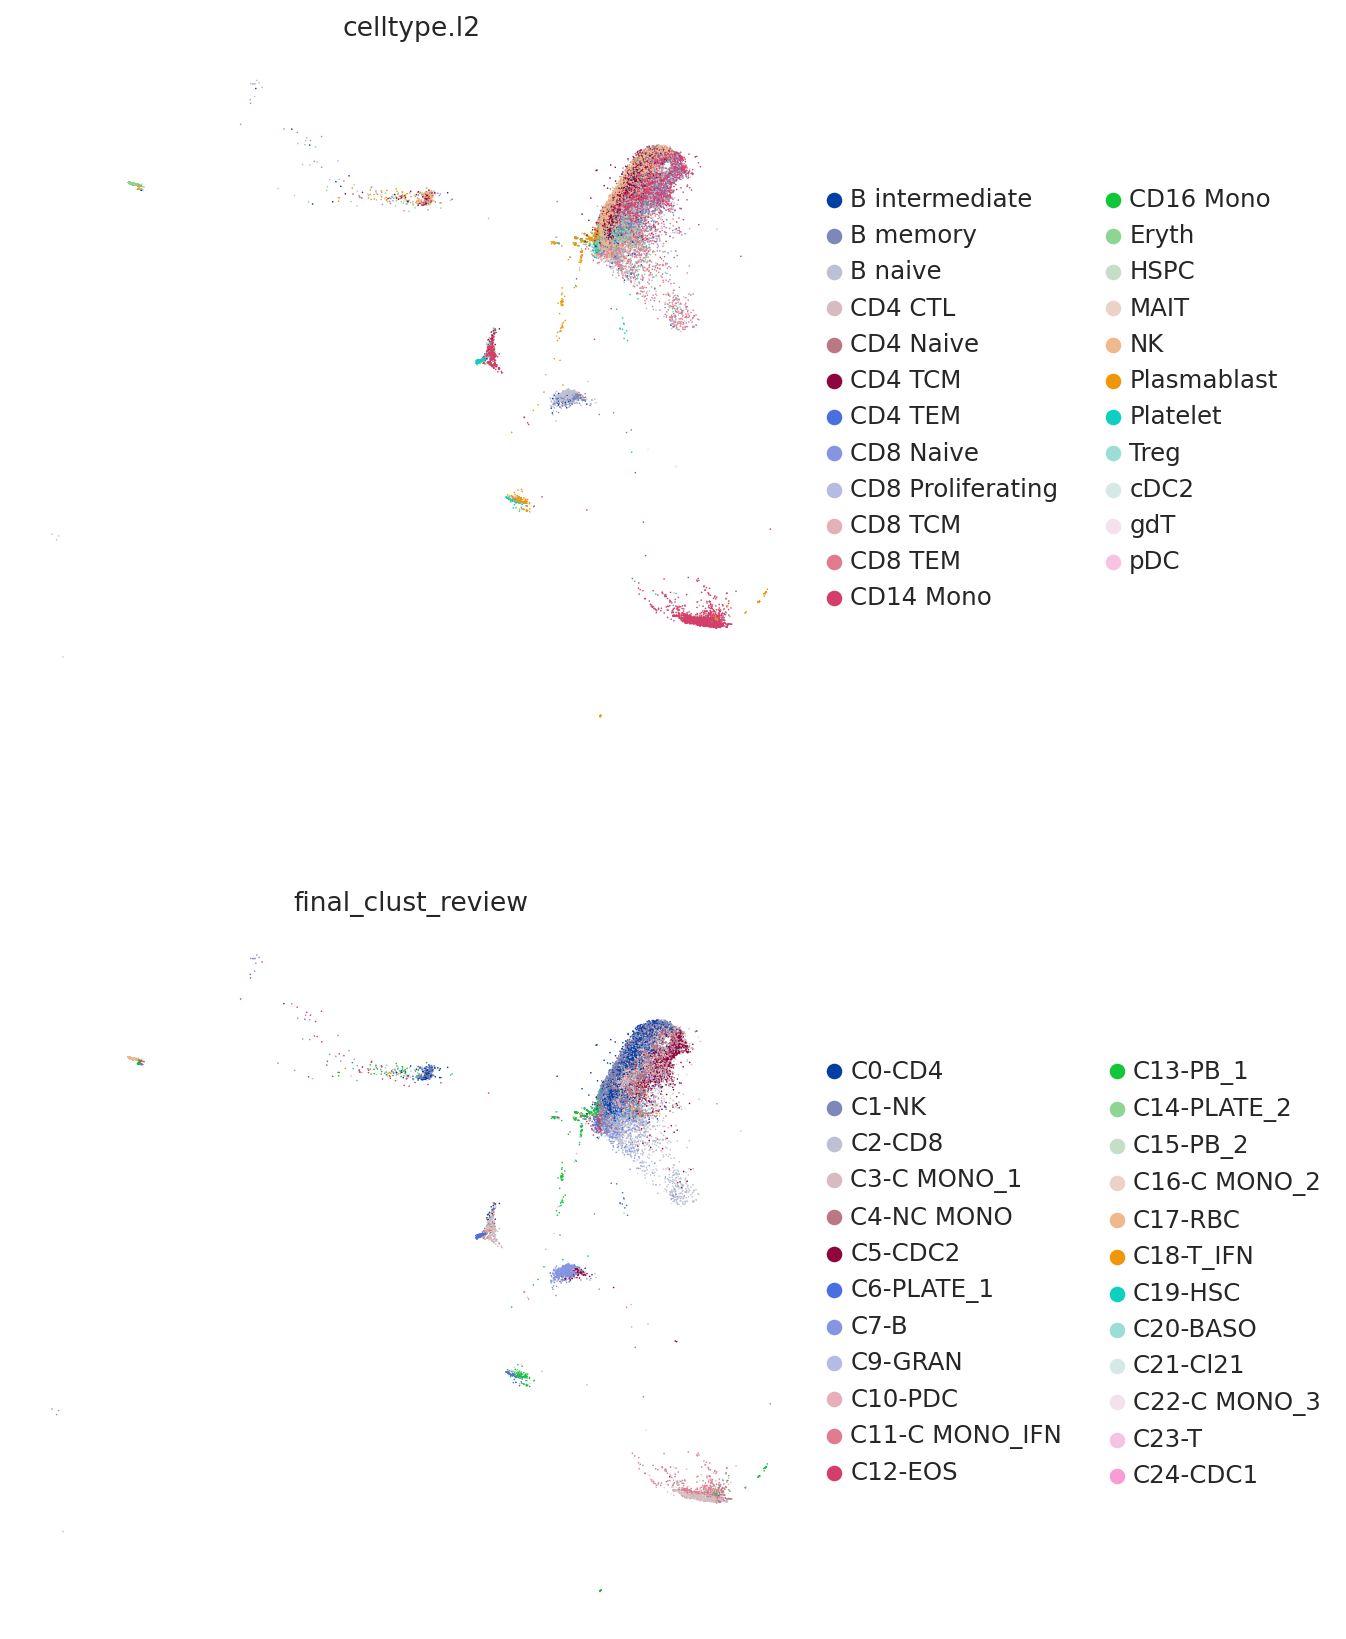

In [31]:
sc.pl.embedding(
    query,
    TOTALVI_UMAP_PROJECT_KEY,
    color=["celltype.l2", "final_clust_review"],
    frameon=False,
    ncols=1,
)

And finally we can combine the umaps together and visualize jointly.

In [27]:
umap_adata = sc.AnnData(
    np.concatenate(
        [
            query.obsm["X_umap_project"],
            adata.obsm["X_umap"],
        ],
        axis=0,
    )
)
umap_adata.obs["celltype"] = np.concatenate(
    [query.obs["celltype.l2"].values, adata.obs["celltype.l2"].values]
)
umap_adata.obs["dataset"] = np.concatenate(
    [query.shape[0] * ["query"], adata.shape[0] * ["reference"]]
)
umap_adata.obsm["X_umap"] = umap_adata.X

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/anndata/_core/anndata.py:1190: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/anndata/_core/anndata.py:1190: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


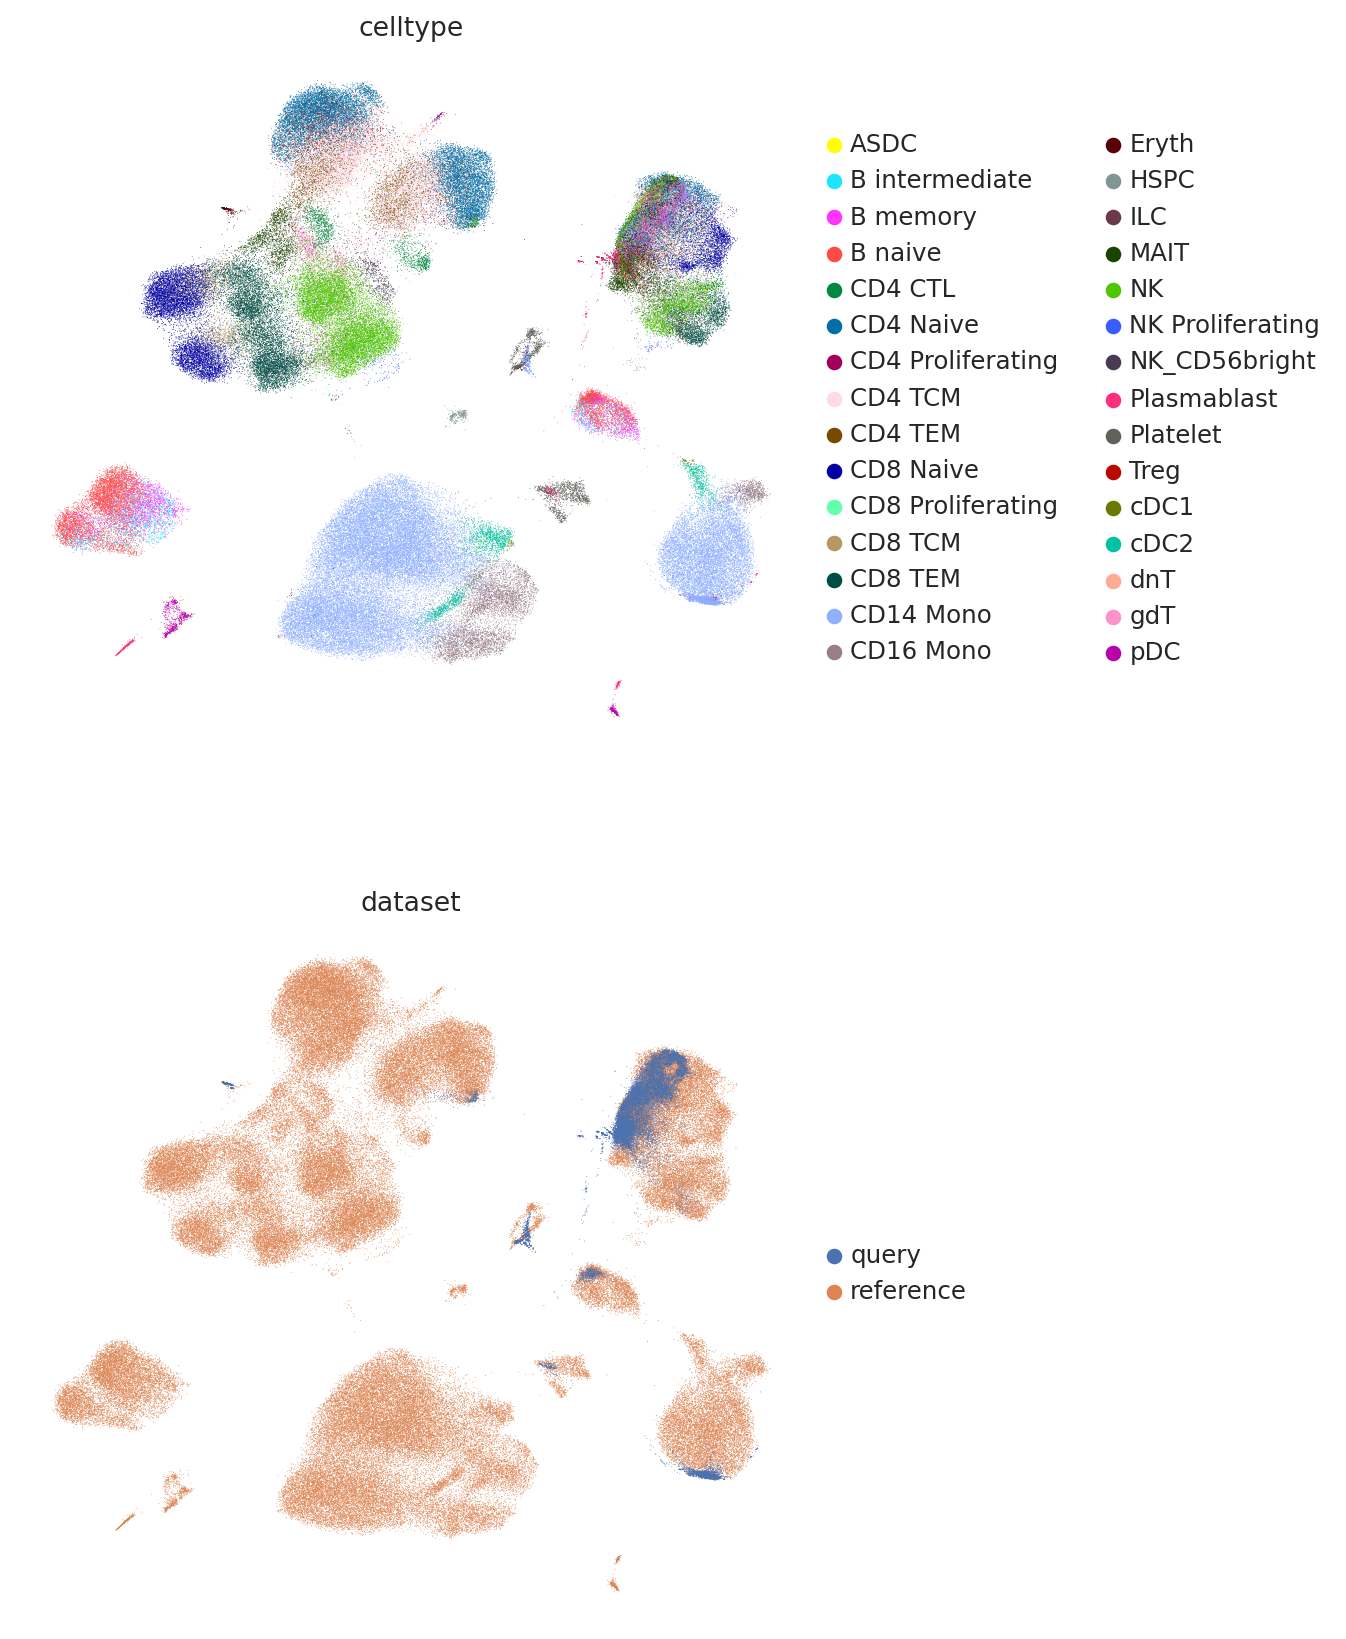

In [28]:
inds = np.random.permutation(np.arange(umap_adata.shape[0]))
sc.pl.umap(
    umap_adata[inds],
    color=["celltype", "dataset"],
    frameon=False,
    ncols=1,
)